In [238]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import swifter
pd.set_option('display.max_columns', None)

In [239]:
recipes = pd.read_csv('./recipes.csv')
requests = pd.read_csv('./requests.csv')
reviews = pd.read_csv('./reviews.csv')
diet = pd.read_csv('./diet.csv')
classify_diet = pd.read_csv('./classify_diet.csv', sep=':;')

/tmp/ipykernel_9262/1304735388.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv('./reviews.csv')
/tmp/ipykernel_9262/1304735388.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  classify_diet = pd.read_csv('./classify_diet.csv', sep=':;')


In [240]:
recipes['RecipeIngredientParts'] = recipes['RecipeIngredientParts'].apply(lambda x: x.replace('\\','').replace('"','').replace('c(', '').replace(')','').replace('(',''))
recipes['RecipeIngredientQuantities'] = recipes['RecipeIngredientQuantities'].apply(lambda x: x.replace('\\','').replace('"','').replace('c(', '').replace(')','').replace('(',''))

def func(x):
    res = []
    for y in x.split(','):
        y = y.strip().lower().replace('-',' ')
        found = classify_diet.loc[classify_diet['Ingredient'] == y]['Diet'].values
        if len(found) == 0:
            print(y)
            continue
        else:
            res.append(found[0])
    return res

# add meal type
classify_diet['Ingredient'] = classify_diet['Ingredient'].str.lower().str.strip().str.replace('(', '').str.replace(')', '').replace('-',' ')
recipes['RecipeIngredientParts'] = recipes['RecipeIngredientParts'].str.lower().str.strip().replace('-',' ')

#classify_diet
print(len(recipes))
recipes['DietIngredient'] = recipes['RecipeIngredientParts'].swifter.allow_dask_on_strings(enable=True).apply(func)

recipes['DietIngredient']

75604


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

0        [Vegan, Vegan, Vegan, Vegan, Vegan, Vegan, Veg...
1        [Vegetarian, Vegetarian, Vegetarian, Vegetaria...
2        [Omnivore, Vegetarian, Vegetarian, Vegan, Vege...
3        [Vegetarian, Vegetarian, Vegetarian, Vegetaria...
4        [Vegan, Vegan, Vegetarian, Vegan, Vegan, Vegan...
                               ...                        
75599    [Vegetarian, Vegan, Vegan, Vegetarian, Vegan, ...
75600    [Vegetarian, Vegan, Vegan, Vegetarian, Vegan, ...
75601    [Omnivore, Vegetarian, Vegetarian, Vegetarian,...
75602                                       [Vegan, Vegan]
75603    [Vegan, Vegan, Vegan, Vegetarian, Vegan, Veget...
Name: DietIngredient, Length: 75604, dtype: object

In [241]:
def decideDiet(x):
    if list(set(x)) == list(['Vegan']):
        return 'Vegan'
    if list(set(x)) == list(['Vegetarian']) or list(set(x)) == list(['Vegan', 'Vegetarian']):
        return 'Vegetarian'
    return 'Omnivore'


recipes['DietRecipe'] = recipes['DietIngredient'].apply(decideDiet)
recipes['DietRecipe']

0        Vegetarian
1        Vegetarian
2          Omnivore
3          Omnivore
4        Vegetarian
            ...    
75599    Vegetarian
75600      Omnivore
75601      Omnivore
75602         Vegan
75603    Vegetarian
Name: DietRecipe, Length: 75604, dtype: object

In [242]:
# join recipes and requests
joined = recipes.merge(reviews, on='RecipeId', how='inner')

# join with diet
joined = joined.merge(diet, on='AuthorId', how='inner')

# join with requests
all = joined.merge(requests, on=['RecipeId', 'AuthorId'], how='inner')

In [243]:
mapping = {
    'RecipeCategory': 'string',
    'RecipeIngredientQuantities': 'string',
    'RecipeIngredientParts': 'string',
    'Name': 'string',
    'AuthorId': 'string',
    'Like': 'bool',
    'Diet': 'string',
    'HighCalories': 'bool',
    'HighProtein': 'string',
    'LowFat': 'bool',
    'LowSugar': 'string',
    'HighFiber': 'bool'
}
df = all.astype(mapping)

In [244]:
# add feature Rated
df['Rated'] = df['Rating'].apply(lambda x: True if x > 0 else False)

# HighProtein and LowSugar have only two values
mapping = {
    'HighProtein': 'bool',
    'LowSugar': 'bool',
}
df = df.astype(mapping)

# add feature MatchesDiet and DietCompatible
def dietComatible(row):
    diet = row['Diet']
    diet_recipe = row['DietRecipe']
    if diet == 'Vegan':
        return diet_recipe == 'Vegan'
    if diet == 'Vegetarian':
        return (diet_recipe == 'Vegan' or diet_recipe == 'Vegetarian')
    return True
df['MatchesDiet'] = df['Diet'] == df['DietRecipe']
df['DietCompatible'] = df.apply(dietComatible, axis=1)

In [245]:
print(df.groupby("Like").size())

Like
False    84503
True     55692
dtype: int64


In [246]:
def boxplot(column):
    sns.boxplot(data=df,x=df[f"{column}"])
    plt.show()

cols = ['Age', 'CookTime', 'PrepTime', 'Calories', 'FatContent', 'SaturatedFatContent', 'CarbohydrateContent', 'FiberContent', 
        'SugarContent', 'ProteinContent', 'SodiumContent', 'CholesterolContent']

#for col in cols:
    #boxplot(col)

In [247]:
mapping = {
    'Diet': 'category',
    'DietRecipe': 'category',
    'RecipeCategory': 'category'
}
df = df.astype(mapping)
df = pd.get_dummies(df, columns=['Diet', 'DietRecipe', 'RecipeCategory'])

In [314]:
import math
import numpy as np
df['RecipeServings'].fillna(1, inplace=True)

df['TimePerServing'] = df['CookTime'] / df['RecipeServings']
df['TotalTime'] = df['CookTime'] + df['PrepTime']
df['TotalTimePerServing'] =  df['TotalTime'] / df['RecipeServings']
df['CaloriesPerServing'] = df['Calories'] / df['RecipeServings']
df['ProteinFatRatio'] = df['ProteinContent'] / (df['FatContent']+0.000001)
df['RequestedTimeRatio'] = df['Time'] / (df['TotalTime']+0.000001)

df['NumberIngredients'] = df['RecipeIngredientParts'].apply(lambda x: len(x.split(',')))

def getRecipePopularity(row):
    recipe_id = row['RecipeId']
    return len(df.loc[(df['RecipeId'] == recipe_id) & (df['Like'] == True)])

df['RecipePopularity'] = df.swifter.allow_dask_on_strings(enable=True).apply(getRecipePopularity, axis=1)
df['RecipePopularity'].fillna(0, inplace=True)
df['RecipePopularity']


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

0         46
1          1
2         46
3          8
4         46
          ..
140190     1
140191     1
140192     1
140193     1
140194     1
Name: RecipePopularity, Length: 140195, dtype: int64

In [249]:
bins = [0, 18, 24, 34, 44, 54, 64, 100]
labels = ['0-18', '19-24', '25-34', '35-44', '45-54', '55-64', '65+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)
df = pd.get_dummies(df, columns=['AgeGroup'])

#df['TimePerServing']


Until here all feature engineering stuff must be done

We can see some outlier which we will remove

In [315]:
# takes around 3 minutes
print(list(df))
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

numeric_cols = ['Age', 'CookTime', 'PrepTime', 'Calories', 'FatContent', 'SaturatedFatContent', 'CarbohydrateContent', 'FiberContent', 
        'SugarContent', 'ProteinContent', 'SodiumContent', 'CholesterolContent', 'TimePerServing','TotalTime','TotalTimePerServing','CaloriesPerServing', 'ProteinFatRatio'
        , 'RequestedTimeRatio', 'NumberIngredients']
df_lof = df[numeric_cols]

scaler = MinMaxScaler()
df_lof = scaler.fit_transform(df_lof)

clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(df_lof)
X_scores = clf.negative_outlier_factor_

df['Outlier'] = X_scores

['RecipeId', 'Name', 'CookTime', 'PrepTime', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'RecipeYield', 'DietIngredient', 'AuthorId', 'Rating', 'Like', 'TestSetId', 'Age', 'Time', 'HighCalories', 'HighProtein', 'LowFat', 'LowSugar', 'HighFiber', 'Rated', 'MatchesDiet', 'DietCompatible', 'Diet_Omnivore', 'Diet_Vegan', 'Diet_Vegetarian', 'DietRecipe_Omnivore', 'DietRecipe_Vegan', 'DietRecipe_Vegetarian', 'RecipeCategory_Beverages', 'RecipeCategory_Bread', 'RecipeCategory_Breakfast', 'RecipeCategory_Lunch', 'RecipeCategory_One dish meal', 'RecipeCategory_Other', 'RecipeCategory_Soup', 'TimePerServing', 'TotalTime', 'TotalTimePerServing', 'CaloriesPerServing', 'ProteinFatRatio', 'RequestedTimeRatio', 'NumberIngredients', 'AgeGroup_0-18', 'AgeGroup_19-24', 'AgeGroup_25-34', 'AgeGroup_35-44', 'AgeGroup_45

In [316]:
train_all = df[df['TestSetId'].isna()]
test = df[df['TestSetId'].notna()]
print(len(train_all))
print(len(test))

97381
42814


In [317]:
threshold = -12
outlier = train_all[train_all['Outlier'] < threshold]
print(len(outlier))
outlier['Name'].unique()

52


<StringArray>
[                                  "Kit's Chocolate Mousse",
                           'Korean Vinegar Sauce Seasoning',
                                             'Dill Pickles',
                                         '110 in the Shade',
                                       'Italian Cheesecake',
                                           'Cheese Souffle',
                                  'Peach Walnut Spice Cake',
                                              'Spiced Beef',
                "Grandpa Rowand's Canadian Pickles (Sweet)",
                                           'Sprouted Bread',
                        'Chocolate Chip Cheesecake Supreme',
               'Margarita Jello Shots of the Jello Masters',
                              'Slow Cooked Beef Stroganoff',
              'Japanese Ponzu Sauce - Vegetarian Variation',
                     'Spicy Thai Dipping Sauce (Nuoc Cham)',
                                'Pineapple Infused Tequila',
          

In [318]:
train_all = train_all[train_all['Outlier'] >= threshold]
print(len(train_all))
train_all.head()

97329


,RecipeId,Name,CookTime,PrepTime,RecipeIngredientQuantities,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,DietIngredient,AuthorId,Rating,Like,TestSetId,Age,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber,Rated,MatchesDiet,DietCompatible,Diet_Omnivore,Diet_Vegan,Diet_Vegetarian,DietRecipe_Omnivore,DietRecipe_Vegan,DietRecipe_Vegetarian,RecipeCategory_Beverages,RecipeCategory_Bread,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup,TimePerServing,TotalTime,TotalTimePerServing,CaloriesPerServing,ProteinFatRatio,RequestedTimeRatio,NumberIngredients,AgeGroup_0-18,AgeGroup_19-24,AgeGroup_25-34,AgeGroup_35-44,AgeGroup_45-54,AgeGroup_55-64,AgeGroup_65+,Outlier,RecipePopularity
163,73440,Bow Ties With Broccoli Pesto,0,1800,"6, 2, 1 1/2, 1/4, 1/2, 4, 1 1/2, 1 1/2, 5, 12","hazelnuts, broccoli florets, fresh parsley lea...",241.3,10.1,1.2,0.0,13.1,31.8,2.3,1.4,6.7,9.0,NaN,"[Vegan, Vegan, Vegan, Vegan, Vegan, Vegan, Veg...",1073154D,2.0,False,NaN,59,1799.844169,False,True,True,True,True,True,True,True,0,0,1,0,0,1,0,0,0,0,0,1,0,0.0,1800,200.0,26.811111,0.663366,0.999913,10,0,0,0,0,0,1,0,-0.996857,46
164,214973,Carne Guisada (Stewed Beef),3000,1200,"2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1","beef round steak, onion, green pepper, garlic ...",331.6,18.9,6.2,92.3,235.8,5.7,1.4,2.6,33.4,1.0,NaN,"[Omnivore, Vegetarian, Vegetarian, Vegan, Vege...",1073154D,2.0,False,NaN,59,4200.065436,True,True,False,True,False,True,False,False,0,0,1,1,0,0,0,0,0,0,0,1,0,3000.0,4200,4200.0,331.600000,1.767196,1.000016,13,0,0,0,0,0,1,0,-1.033010,1
165,87925,Veggie Puff Pastries,2400,1500,"1, 1, 1/2, 3 1/2, 2, 1, 1, 2, 1, 1, 1","puff pastry, egg, sweet potato, asparagus spea...",775.0,50.4,15.0,68.1,405.1,69.8,5.0,6.1,12.1,4.0,NaN,"[Vegetarian, Omnivore, Vegan, Vegan, Vegetaria...",1073154D,2.0,False,NaN,59,3900.449168,True,True,True,True,True,True,False,False,0,0,1,1,0,0,0,0,0,0,0,1,0,600.0,3900,975.0,193.750000,0.240079,1.000115,11,0,0,0,0,0,1,0,-1.049366,7
166,111514,Delicious Fluffy Pancakes,1500,300,"1 1/2, 1 1/2, 1, 1 1/4, 3, 1, 2","flour, baking powder, salt, milk, butter, egg,...",170.6,6.6,3.8,43.2,553.5,23.5,0.6,3.3,4.5,1.0,8 pancakes,"[Vegetarian, Vegetarian, Vegan, Vegetarian, Ve...",1073154D,2.0,False,NaN,59,1800.542375,True,True,False,True,False,True,False,False,0,0,1,1,0,0,0,0,1,0,0,0,0,1500.0,1800,1800.0,170.600000,0.681818,1.000301,7,0,0,0,0,0,1,0,-1.048844,9
167,8782,Garden Chicken,2100,1500,"4, 1, 5, 1, 1, 1, 4, 1, 1/2, 1/2, 2, 1, 1, 1, 1/3","boneless skinless chicken breast halves, garli...",436.2,19.1,10.6,95.6,501.4,37.3,2.2,3.2,27.8,6.0,1 casserole,"[Omnivore, Vegetarian, Vegetarian, Vegetarian,...",1073154D,NaN,False,NaN,59,3601.194876,True,True,False,True,True,False,False,False,0,0,1,1,0,0,0,0,0,0,0,1,0,350.0,3600,600.0,72.700000,1.455497,1.000332,13,0,0,0,0,0,1,0,-0.952657,20


In [319]:
print(train_all.groupby("Like").size())

Like
False    84456
True     12873
dtype: int64


The class labels are uneven distributed. Therefore, we sample only a part of the False Like labels

In [320]:
false_sample = train_all[train_all['Like'] == False].sample(frac=0.7, random_state=1)
true_sample = train_all[train_all['Like'] == True]
true_sample = pd.concat([true_sample, true_sample, true_sample, true_sample])

train_all = pd.concat([false_sample, true_sample])
print(len(train_all))
print(train_all.groupby("Like").size())

110611
Like
False    59119
True     51492
dtype: int64


In [321]:
print(train_all[train_all['Diet_Vegetarian'] == True].groupby("Like").size())

Like
False    50265
True     40632
dtype: int64


In [338]:
from sklearn.model_selection import train_test_split

""" 

"""

X_cols = [
 'CookTime',
 'PrepTime',
 'Calories',
 'FatContent',
 'SaturatedFatContent',
 'CholesterolContent',
 'SodiumContent',
 'CarbohydrateContent',
 'FiberContent',
 'SugarContent',
 'ProteinContent',
 'Age',
 'Time',
 'HighCalories',
 'HighProtein',
 'LowFat',
 'LowSugar',
 'HighFiber',
 'Rated',
 'MatchesDiet',
 'DietCompatible',
 'AgeGroup_0-18', 
 'AgeGroup_19-24', 
 'AgeGroup_25-34', 
 'AgeGroup_35-44', 
 'AgeGroup_45-54', 
 'AgeGroup_55-64', 
 'AgeGroup_65+',

  'Diet_Omnivore',
 'Diet_Vegan',
 'Diet_Vegetarian',
 'DietRecipe_Omnivore',
 'DietRecipe_Vegan',
 'DietRecipe_Vegetarian',
 'RecipeCategory_Beverages',
 'RecipeCategory_Bread',
 'RecipeCategory_Breakfast',
 'RecipeCategory_Lunch',
 'RecipeCategory_One dish meal',
 'RecipeCategory_Other',
 'RecipeCategory_Soup',

 'NumberIngredients',

 'RecipePopularity',


 'TimePerServing','TotalTime','TotalTimePerServing','CaloriesPerServing','ProteinFatRatio','RequestedTimeRatio'
 ]
X = train_all[X_cols]
y = train_all['Like']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

In [339]:
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)


print(classification_report(y_val, y_pred))
print(balanced_accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.90      0.94     19509
        True       0.89      0.99      0.94     16993

    accuracy                           0.94     36502
   macro avg       0.94      0.94      0.94     36502
weighted avg       0.94      0.94      0.94     36502

0.9416788812193949


In [340]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)


print(classification_report(y_val, y_pred))
print(balanced_accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.88      0.79      0.83     19509
        True       0.78      0.88      0.83     16993

    accuracy                           0.83     36502
   macro avg       0.83      0.83      0.83     36502
weighted avg       0.83      0.83      0.83     36502

0.8310702916971806


In [341]:
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score


#Creating an XGBoost classifier
model = xgb.XGBClassifier()

#Training the model on the training data
model.fit(X_train, y_train)

#Making predictions on the test set
predictions = model.predict(X_val)

print(classification_report(y_val, predictions))
print(balanced_accuracy_score(y_val, predictions))
#0.8514768545247124
#0.9117869878047706


              precision    recall  f1-score   support

       False       0.96      0.87      0.91     19509
        True       0.86      0.95      0.91     16993

    accuracy                           0.91     36502
   macro avg       0.91      0.91      0.91     36502
weighted avg       0.91      0.91      0.91     36502

0.9117869878047706


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

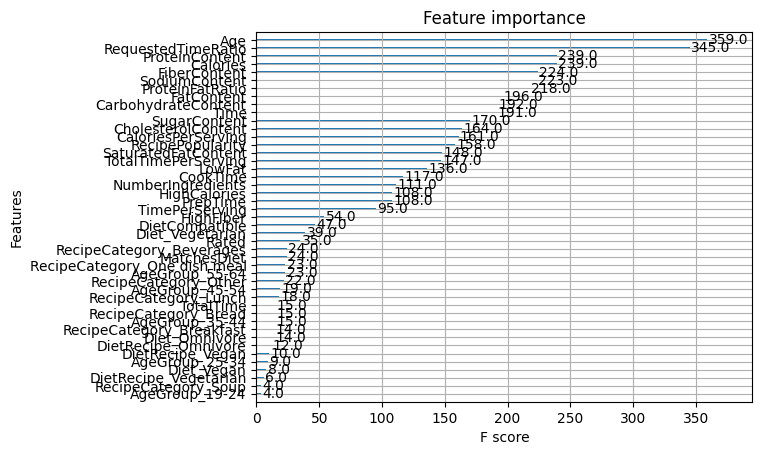

In [342]:
xgb.plot_importance(model)